# Redes Recurrentes

Vamos a usar el dataset de IMDB de 50k reviews disponible en [kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gzip
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset,DataLoader


from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange


In [ ]:
nltk.download("stopwords") # Descargamos las stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Seteamos la semilla
seed =14

In [ ]:
#imdbpd.read_csv('/content/drive/MyDrive/Aprendizaje Profundo/Edición 2023/Notebooks 2023/imdb_dataset.csv')
# Leemos el dataset
# = 'imdb_dataset.csv'
df = pd.read_csv("/content/drive/MyDrive/Aprendizaje Profundo/Edición 2023/Notebooks 2023/imdb_dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#df = df.iloc[:500]

In [ ]:
X = df['review'].values
y = df['sentiment'].values

# Dividir el conjunto de datos en conjuntos de entrenamiento, validación y test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

print(f'Cantidad de datos en train: {X_train.shape[0]}')
print(f'Cantidad de datos en validación: {X_val.shape[0]}')
print(f'Cantidad de datos en test: {X_test.shape[0]}')

Cantidad de datos en train: 35000
Cantidad de datos en validación: 7500
Cantidad de datos en test: 7500


## Pequeña inspección de los datos

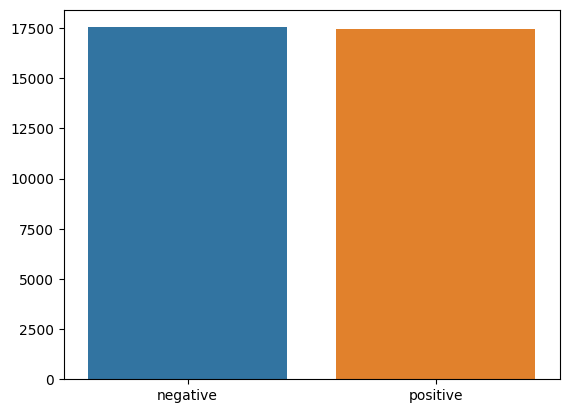

In [ ]:
target_dist = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=target_dist.values)
plt.show()

## Procesamiento de texto


El preprocesamiento de texto y la tokenización son un primer paso fundamental. Primero, limpiamos los datos del texto eliminando puntuación, espacios adicionales y números.

Luego transformamos oraciones en palabras individuales, eliminamos palabras comunes (conocidas como *stop words*) y obtenemos las 1000 palabras más utilizadas en el conjunto de datos. Luego, a estas palabras se les asigna un identificador único, formando un diccionario para one-hot encoding.

Básicamente, el código convierte las oraciones del texto original en secuencias de estos identificadores únicos, traduciendo el lenguaje humano a un formato que un modelo de aprendizaje automático pueda entender.

In [ ]:
def preprocess_string(string):
    # Remove all non-word characters (everything except numbers and letters)
    string = re.sub(r"[^\w\s]", '', string)
    # Replace all runs of whitespaces with no space
    string = re.sub(r"\s+", '', string)
    # replace digits with no space
    string = re.sub(r"\d", '', string)
    return string

In [ ]:
string1 = "💜"
string2 = "Holaaaa!!"
string3 = "o???"

print('Algunos ejemplos:')
print(f"'{string1}' se transforma en: {preprocess_string(string1)}")
print(f"'{string2}' se transforma en: {preprocess_string(string2)}")
print(f"'{string3}' se transforma en: {preprocess_string(string3)}")

Algunos ejemplos:
'💜' se transforma en: 
'Holaaaa!!' se transforma en: Holaaaa
'o???' se transforma en: o


In [ ]:
for sentence in X_train:
  print(sentence)
  break

One of my all-time favorite so-laughably-lousy-that-it's-totally-lovable el cheapo and stinko nickel'n'dime independent horror creature features, an enjoyably dreadful marvel that was released by the formidably fecund exploitation outfit Crown International Pictures so it could play numerous crappy double bills at countless drive-ins back in the 70's and eventually wound up being rerun like crazy on several small-time secondary cable stations throughout the 80's. I naturally first saw this gloriously ghastly abomination on late-night television one fateful Saturday evening while in my early teens and have had a deep-seated, albeit completely irrational abiding fondness for it ever since.<br /><br />A meteorite falls out of the sky and crashes into the still waters of a tranquil country lake, thereby causing a heretofore dormant dinosaur egg to hatch. Of course, the baby dino immediately grows into a gigantic waddling, grunting, teeth-gnashing prehistoric behemoth with goofy flippers, a

In [ ]:
def tokenize(x_train,y_train,x_val,y_val):

    word_list = []
    stop_words = set(stopwords.words('english'))
    # Recorro cada ejemplo de entrenamiento, en este caso cada review
    for sentence in x_train:
        # Comenzamos el proceso de tokenización
        # pasando todo a minuscula y obteniendo los tokens
        for word in sentence.lower().split():
            word = preprocess_string(word)
            #Filtro por stop words
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    #corpus is Counter({'br': 80161, 'movie': 58670, 'film': 52009, ...})

    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    #corpus_ is ['br', 'movie', 'film', 'one', 'like', 'good', 'even',..]


    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    # onehot_dict is {'br': 1, 'movie': 2, 'film': 3, 'one': 4......}


    # tokenize
    final_list_train = []
    final_list_test = []

    # Para cada ejemplo de entrenamiento y validación voy a armar una lista que contenga
    # la ocurrencia de cada palabra dentro de la review
    for sentence in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sentence.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sentence in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sentence.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test), onehot_dict


x_train,y_train,x_val,y_val,vocab = tokenize(X_train,y_train,X_val,y_val)


<ipython-input-12-828efd8bcb35>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test), onehot_dict


In [ ]:
print(x_train[10])
print(y_train[10])


[31, 150, 3, 20, 25, 3, 182, 41, 531, 938, 4, 58, 434, 201, 24, 52, 929, 174, 53, 377, 131, 878, 57, 279, 1, 284, 612, 292, 340, 28, 886, 4, 340, 28, 897, 449, 243, 41, 3, 452, 108, 452, 31, 51, 304, 67, 424, 130, 3, 120, 130, 103, 50, 31, 365, 25, 448, 472, 1, 80, 131, 31, 12, 1, 1]
0


In [ ]:
print(x_val[12])
print(y_val[12])

[31, 956, 715, 753, 199, 24, 9, 860, 293, 630, 255, 446, 131, 774, 51, 530, 50, 145, 408, 19, 681, 87, 125, 16, 954]
1


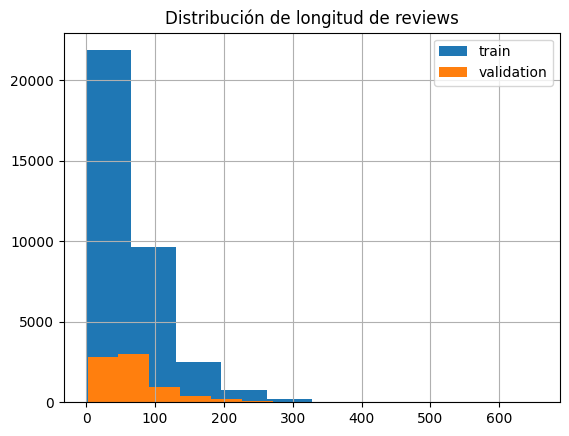

In [ ]:
rev_len_train = [len(i) for i in x_train]
rev_len_val = [len(i) for i in x_val]

pd.Series(rev_len_train).hist(label ='train')
pd.Series(rev_len_val).hist(label='validation')
plt.legend()
plt.title('Distribución de longitud de reviews')
plt.show()

## Preparando los datos para el modelo

Dada la longitud variable de los tokens de cada review, es necesario estandarizarlos para mantener la coherencia. Como la mayoría de las reseñas contienen menos de 500 tokens, estableceremos 500 como longitud fija para todas las reviews.

In [ ]:
x_train.shape

(35000,)

In [ ]:
np.zeros((10, 3),dtype=int)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
def padding(sentences, seq_len):

    features = np.zeros((len(sentences), seq_len),dtype=int)
    for index, review in enumerate(sentences):
        if len(review) != 0:
            features[index, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding(x_train,500)
x_val_pad = padding(x_val,500)

In [ ]:
print(x_train_pad.shape)
print(x_val_pad.shape)

(35000, 500)
(7500, 500)


In [ ]:
index= 154
print(x_train[index])
print('----')
print(x_train_pad[index][:])

[672, 62, 120, 125, 272, 59, 280, 89, 93, 70, 81, 163, 1, 22, 53, 64, 27, 120, 401, 480, 66, 452, 249, 3, 49, 13, 84, 734, 758, 4, 1, 182, 808, 552, 574, 9, 206, 646, 93, 646, 961, 572, 78, 9, 138, 303, 341, 50, 728, 158, 9, 886, 1, 944, 516, 961, 552, 172, 120, 808, 225, 859, 756, 7, 553, 117, 86, 1, 3, 188, 272, 513, 469, 3, 45, 47, 842, 135, 62, 1, 535, 844, 131, 791, 10, 58, 18, 844, 76, 33, 359, 186, 227, 844, 348, 297, 381, 511, 49, 1, 988, 341, 3, 598, 442, 147, 320, 652, 257, 804, 349, 299, 127, 45, 652]
----
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   

De esta manera, el resultado del padding es transformar cada review (sentence) en un vector de dimensión 500.

## Definimos los Tensores de entrada

Recordemos que la clase `Dataloader` es una clase que permite cargar los datos y recibe los siguientes inputs:

- Un dataset a cargar: Puede ser un tensor, una lista de tensores o cualquier estructura de datos que contenga los datos a modelar.
- `shuffle`: Cuando este parámetro es `True` controla si se deben barajar los datos antes de dividirlos en lotes. Barajar los datos es útil para evitar que el modelo aprenda el orden en el que se presentaron los ejemplos de entrenamiento y, por lo tanto, para mejorar la generalización.
- `batch_size`: Establece el tamaño de lote, es decir, cuántos ejemplos se cargarán a la vez. El conjunto de datos se divide en lotes del tamaño batch_size, y el modelo se entrena en cada lote por separado. Usar lotes en lugar de pasar todos los datos a la vez puede hacer que el entrenamiento sea más eficiente y gestionable.





In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))


# dataloaders
batch_size = 50


# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)


# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Training set:')
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)


# obtain one batch of training data
dataiter = iter(valid_loader)
sample_x, sample_y = next(dataiter)

print('\n')
print('Validation dataset:')
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Training set:
Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  22, 102, 278],
        [  0,   0,   0,  ..., 434,   6, 433],
        [  0,   0,   0,  ...,  38, 219,  42],
        ...,
        [  0,   0,   0,  ..., 705,  55, 239],
        [  0,   0,   0,  ..., 113, 260, 754],
        [  0,   0,   0,  ..., 128, 239,   3]])
Sample output: 
 tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0])


Validation dataset:
Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 318,  81, 239],
        [  0,   0,   0,  ...,  62,  76,  52],
        [  0,   0,   0,  ..., 275,  16,   1],
        ...,
        [  0,   0,   0,  ..., 175, 678,  78],
        [  0,   0,   0,  ..., 207, 113, 233],
        [  0,   0,   0,  ..., 572, 879,  12]])
Sample output: 
 tensor([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 

## Definimos el modelo



### Usando una capa de embeddings

Documentación:

- [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html): Se utiliza para crear una capa de embedding en una red neuronal. Esta capa se utiliza para aprender representaciones vectoriales densas de palabras en un espacio de características continuas. La llamada `nn.Embedding(vocab_size, embedding_dim)` realiza lo siguiente:

- `vocab_size`: Es el tamaño del vocabulario, es decir, el número total de palabras o ítems únicos en tu conjunto de datos. Cada palabra se mapea a un número entero único, y `vocab_size` representa la cantidad de valores enteros distintos que pueden tomar. Cada valor entero se asocia con un vector de embedding único.

- `embedding_dim`: Especifica la dimensión de los vectores de embedding que se aprenderán para representar cada palabra. Cada palabra se representará como un vector de `embedding_dim` dimensiones.

Cuando se crea una instancia de `nn.Embedding(vocab_size, embedding_dim)`, se está configurando una capa de embedding que entrenará junto con el resto de tu modelo durante el proceso de entrenamiento. Esta capa mapea cada palabra única (identificada por un valor entero) a un vector de embedding correspondiente de `embedding_dim` dimensiones. Estos vectores de embedding se pueden aprender y ajustar para capturar relaciones semánticas entre las palabras en función de los patrones presentes en los datos de entrenamiento.

Cuando se pasa un valor entero (por ejemplo, el índice de una palabra) a esta capa de embedding, devuelve el vector de embedding asociado con ese valor entero. Los vectores de embedding resultantes se utilizan como entrada para la red neuronal, lo que permite a la red aprender representaciones más ricas y significativas de las palabras en lugar de simplemente tratar las palabras como índices enteros. Esto es útil en tareas de procesamiento de lenguaje natural (NLP) y muchas otras aplicaciones de aprendizaje automático.

### LSTM model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self,
                 layers_number, #
                 vocab_size, # Tambien se lo suele escribir como input_size
                 hidden_dim, #
                 embedding_dim, #
                 dropout=0.5):

        super(LSTMModel,self).__init__()

        self.output_dim = output_dim # La cantidad de clases a predecir
        self.hidden_dim = hidden_dim #El numero de nodos en cada capa LSTM (similar a una full conected layer)

        self.layers_number = layers_number # Número de capas LSTM en la red
        self.vocab_size = vocab_size # Tamaño del vocabulario, es decir el número de palabras distintas

        # embedding and LSTM layers
        # Dimension de los vectores de embeddings para representar las palabras
        # Es una matriz que tiene tantas filas como palabras y tantas columnas como la dimension
        # del vector que definimos
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # La capa lstm toma como entrada los embeddings
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_dim, #Representa la cantidad de features en el estado oculto
                           num_layers=layers_number, #Numero de capas recurrentes
                            batch_first=True) #El batch es la primera dimension, nuestros datos tienen la dimension (batch_size, seq_len, features)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.lineal = nn.Linear(self.hidden_dim, output_dim) #Transforma las LSTM en un vector de dimension igual al numero de clases
        self.sigmoid = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0) # Calcula el tamaño del lote dentro de los datos de entrada

        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: BATCH x SENQUENCE_LENGHT x FEATURES   since batch = True (Features es la cantidad total de palabras)
        #print(embeds.shape)  #[X, Y,Z]
        lstm_out, hidden = self.lstm(embeds, hidden) # Obtenemos las celdas de salidas y un nuevo estado oculto

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # Redimensiona para tener la forma (batch_size*seq_len, hidden_dim) -> tensor de 2 dimensiones

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.lineal(out)

        # sigmoid function
        sig_out = self.sigmoid(out)

        #Redimensionamos para tener dimension (batch_size, -1),
        #es decir para obtener las predicciones finales de la red LSTM de cada lote
        sig_out = sig_out.view(batch_size, -1)


        sig_out = sig_out[:, -1] # Selecciona la ultima columna de la variable sig_out que contiene, en general, los resultados de la capa lineal

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.layers_number,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.layers_number,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
layers_number = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
#Como tenemos un problema de clasificacion binaria y aplicamos la funcion sigmoide
# La salida es un tensor unimensional cuyo valor de activacion nos indica la probabilidad
# de pertenencia a la clase
output_dim = 1
hidden_dim = 256


model = LSTMModel(layers_number,
                  vocab_size,
                  hidden_dim,
                  embedding_dim,
                  dropout=0.5)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

#moving to gpu
model.to(device)
print(model)

LSTMModel(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lineal): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# loss and optimization functions

lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred,label):
    #Nos aseguramos que tanto pred como label tengan las mismas dimensiones
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item() #Cantidad de predicciones correctas


In [ ]:
clip = 5
EPOCHS = 50
valid_loss_min = np.Inf

# train for some number of epochs
epoch_tr_loss = []
epoch_vl_loss = []

epoch_tr_acc = []
epoch_vl_acc = []


#for epoch in trange(EPOCHS):
for epoch in trange(EPOCHS):
  train_losses = []
  train_acc = 0.0
  model.train()

  # initialize hidden state
  # Establecemos el estado inicial en cero
  hidden = model.init_hidden(batch_size)

  # Dado que el dataset tiene x datos y pusimos un batch de y
  # vamos a hacer n pasos de entrenamiento
  for inputs, labels in tqdm(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Creamos nuevas variables para el estado oculto,
      # de otra manera propagariamos a lo largo de toda la historia de entrenamiento teniendo problemas del explosion del gradiente.
      # El estado oculto se actualiza en cada paso de tiempo
      # Con la linea siguiente "devinculamos" el estado oculto de cualquier calculo anterior
      # y solo extraemos sus valores copiandolos con each.data
      hidden = tuple([each.data for each in hidden])

      model.zero_grad()
      output,hidden = model(inputs,hidden) #Realizamos un paso hacia adelante

      # Calculamos la loss y hacemos el backpropagation
      loss = criterion(output.squeeze(), labels.float())
      loss.backward()

      train_losses.append(loss.item())

      # calculating accuracy
      accuracy = acc(output,labels)
      train_acc += accuracy

      #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
      # Limita la norma de los gradientes al valor especificado en clip
      # model.parameters() es una lista de los parámetros del modelo,
      # que son tensores en los que se almacenan los gradientes después de realizar la retropropagación del error.
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()

  val_h = model.init_hidden(batch_size)
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:
          val_h = tuple([each.data for each in val_h])

          inputs =  inputs.to(device)
          labels = labels.to(device)


          output, val_h = model(inputs, val_h)
          val_loss = criterion(output.squeeze(), labels.float())


          val_losses.append(val_loss.item())

          accuracy = acc(output,labels)
          val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)

  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)

  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)

  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)

  print(f'Epoch {epoch+1}')
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

  if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), 'state_dict.pt')
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
      valid_loss_min = epoch_val_loss
  print(25*'==')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6848865273169109 val_loss : 0.6929526396592458
train_accuracy : 52.44571428571428 val_accuracy : 50.28
Validation loss decreased (inf --> 0.692953).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.6918238117865154 val_loss : 0.6928827305634816
train_accuracy : 52.24285714285715 val_accuracy : 51.58666666666667
Validation loss decreased (0.692953 --> 0.692883).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.6334374865038054 val_loss : 0.47095642844835917
train_accuracy : 60.70285714285715 val_accuracy : 77.57333333333334
Validation loss decreased (0.692883 --> 0.470956).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.40253975655351365 val_loss : 0.37639096836249036
train_accuracy : 82.23142857142857 val_accuracy : 83.41333333333333
Validation loss decreased (0.470956 --> 0.376391).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.3426733126704182 val_loss : 0.36120889653762184
train_accuracy : 85.46285714285715 val_accuracy : 84.64
Validation loss decreased (0.376391 --> 0.361209).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.31042795864599093 val_loss : 0.3524971609314283
train_accuracy : 86.84857142857143 val_accuracy : 84.58666666666666
Validation loss decreased (0.361209 --> 0.352497).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.2887621143886021 val_loss : 0.35043469299872715
train_accuracy : 88.0 val_accuracy : 84.98666666666666
Validation loss decreased (0.352497 --> 0.350435).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.2637137856440885 val_loss : 0.34980597853660583
train_accuracy : 89.16 val_accuracy : 85.13333333333334
Validation loss decreased (0.350435 --> 0.349806).  Saving model ...


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.23055290052933353 val_loss : 0.35922155767679215
train_accuracy : 90.60285714285715 val_accuracy : 84.73333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.18867025506283555 val_loss : 0.38533813109000525
train_accuracy : 92.63142857142857 val_accuracy : 84.29333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 11
train_loss : 0.13970782276775157 val_loss : 0.47321404427289965
train_accuracy : 94.84 val_accuracy : 83.73333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 12
train_loss : 0.09227911568912012 val_loss : 0.575896430114905
train_accuracy : 96.82857142857144 val_accuracy : 83.44


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 13
train_loss : 0.05956360163100596 val_loss : 0.6775570258498191
train_accuracy : 98.07142857142857 val_accuracy : 83.21333333333332


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 14
train_loss : 0.047049900553289004 val_loss : 0.7693025206526121
train_accuracy : 98.47142857142858 val_accuracy : 83.65333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 15
train_loss : 0.035948926760465835 val_loss : 0.805557853281498
train_accuracy : 98.83714285714285 val_accuracy : 83.77333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 16
train_loss : 0.02753900995615238 val_loss : 0.8388671882947286
train_accuracy : 99.15428571428572 val_accuracy : 83.30666666666666


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 17
train_loss : 0.027517849238606038 val_loss : 0.8145875023802122
train_accuracy : 99.12571428571428 val_accuracy : 83.36


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 18
train_loss : 0.02714498078749914 val_loss : 0.8459795345862706
train_accuracy : 99.12285714285714 val_accuracy : 83.56


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 19
train_loss : 0.01733855143929499 val_loss : 0.9643318292498588
train_accuracy : 99.47142857142856 val_accuracy : 83.09333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 20
train_loss : 0.01627184039200074 val_loss : 1.0282133891185126
train_accuracy : 99.46857142857142 val_accuracy : 83.58666666666666


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 21
train_loss : 0.021816310896039276 val_loss : 1.057526979049047
train_accuracy : 99.23714285714286 val_accuracy : 83.96000000000001


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 22
train_loss : 0.013252251284138766 val_loss : 1.0517552277445794
train_accuracy : 99.54285714285714 val_accuracy : 83.28


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 23
train_loss : 0.013881742084413418 val_loss : 1.0165991662815212
train_accuracy : 99.52857142857144 val_accuracy : 83.64


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 24
train_loss : 0.01728715020011545 val_loss : 0.9878329053521157
train_accuracy : 99.42 val_accuracy : 82.98666666666666


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 25
train_loss : 0.012619459518006935 val_loss : 1.1297353678693374
train_accuracy : 99.5657142857143 val_accuracy : 83.46666666666667


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 26
train_loss : 0.013737561425722172 val_loss : 1.033676716486613
train_accuracy : 99.55714285714285 val_accuracy : 83.57333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 27
train_loss : 0.013153845947469692 val_loss : 1.09786099255085
train_accuracy : 99.56 val_accuracy : 83.14666666666668


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 28
train_loss : 0.01605245618097667 val_loss : 1.1234733267625172
train_accuracy : 99.45714285714286 val_accuracy : 83.45333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 29
train_loss : 0.011503084973904022 val_loss : 1.0832245977719626
train_accuracy : 99.63428571428572 val_accuracy : 84.04


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 30
train_loss : 0.008826743970405785 val_loss : 1.1407359073062737
train_accuracy : 99.68857142857142 val_accuracy : 83.6


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 31
train_loss : 0.012640829573182211 val_loss : 1.0640751834368953
train_accuracy : 99.5657142857143 val_accuracy : 83.41333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 32
train_loss : 0.01321011836129141 val_loss : 1.0299763797720274
train_accuracy : 99.56 val_accuracy : 83.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 33
train_loss : 0.01146399712163007 val_loss : 1.0312978631258012
train_accuracy : 99.62 val_accuracy : 83.28


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 34
train_loss : 0.01182853654507718 val_loss : 1.0837301034728686
train_accuracy : 99.61142857142858 val_accuracy : 83.86666666666667


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 35
train_loss : 0.00818385179152496 val_loss : 1.177373669842879
train_accuracy : 99.73428571428572 val_accuracy : 83.85333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 36
train_loss : 0.010055833444561619 val_loss : 1.1292379637559256
train_accuracy : 99.67714285714285 val_accuracy : 84.18666666666667


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 37
train_loss : 0.006802644536932608 val_loss : 1.290368412534396
train_accuracy : 99.78 val_accuracy : 83.45333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 38
train_loss : 0.010638611911235784 val_loss : 1.0162584455311299
train_accuracy : 99.67714285714285 val_accuracy : 83.76


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 39
train_loss : 0.010152220627569477 val_loss : 1.1088422199090322
train_accuracy : 99.64571428571428 val_accuracy : 82.33333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 40
train_loss : 0.009548420710125356 val_loss : 1.1265900719165802
train_accuracy : 99.68285714285715 val_accuracy : 83.65333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 41
train_loss : 0.005753110292511597 val_loss : 1.1955383732914924
train_accuracy : 99.81428571428572 val_accuracy : 83.37333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 42
train_loss : 0.009583153519327295 val_loss : 1.1289050595959027
train_accuracy : 99.7057142857143 val_accuracy : 83.29333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 43
train_loss : 0.0071518147160168155 val_loss : 1.2755078983306884
train_accuracy : 99.80857142857143 val_accuracy : 83.0


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 44
train_loss : 0.011261430715811522 val_loss : 1.2330928995211918
train_accuracy : 99.60857142857142 val_accuracy : 83.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 45
train_loss : 0.008092871307100203 val_loss : 1.2954515582074722
train_accuracy : 99.72571428571429 val_accuracy : 83.67999999999999


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 46
train_loss : 0.006868001367656688 val_loss : 1.2326486446460088
train_accuracy : 99.78571428571429 val_accuracy : 83.85333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 47
train_loss : 0.003630050567359311 val_loss : 1.3816520985464256
train_accuracy : 99.88857142857142 val_accuracy : 83.69333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 48
train_loss : 0.009705367935618726 val_loss : 1.3136805716156958
train_accuracy : 99.68285714285715 val_accuracy : 83.29333333333334


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 49
train_loss : 0.009288727384903593 val_loss : 1.2620991366108258
train_accuracy : 99.70857142857142 val_accuracy : 83.45333333333333


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 50
train_loss : 0.0068155680832660435 val_loss : 1.3436554620663326
train_accuracy : 99.78285714285714 val_accuracy : 83.54666666666667


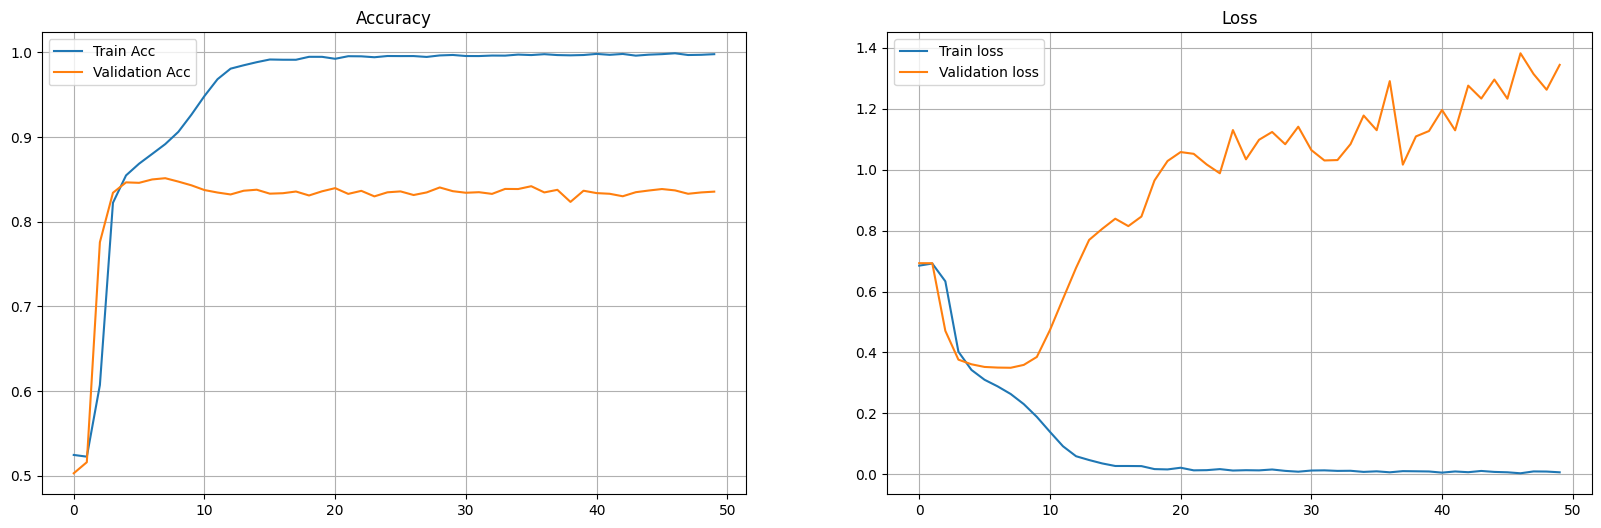

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()


plt.show()


In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())


index = 50
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')


Return to the 36th Chamber is one of those classic Kung-Fu movies which Shaw produces back in the 70s and 80s, whose genre is equivalent to the spaghetti westerns of Hollywood, and the protagonist Gordon Liu, the counterpart to the western's Clint Eastwood. Digitally remastered and a new print made for the Fantastic Film Fest, this is "Presented in Shaw Scope", just like the good old days.<br /><br />This film is a simple story of good versus evil, told in 3 acts, which more or less sums up the narrative of martial arts films in that era.<br /><br />Act One sets up the premise. Workers in a dye-mill of a small village are unhappy with their lot, having their wages cut by 20% by incoming manchu gangsters. They can't do much about their exploitation because none of them are martial arts skilled to take on the gangsters, and their boss. At first they had a minor success in getting Liu to impersonate a highly skilled Shaolin monk (one of the best comedy sequences), but their rouse got expo

## Ejercicios extras


Una vez que hemos implementado la arquitectura básica de la red, podemos comenzar a experimentar con distintas modificaciones para lograr mejores resultados. Algunas tareas posibles son:

- Agregar más capas recurrentes
- Probar otros largos de secuencias máximas
- Probar diferentes valores de learning rate

El material de está notebook está fuertemente basado en el material que se encuentra en [datacamp](https://www.datacamp.com/tutorial/nlp-with-pytorch-a-comprehensive-guide).


Otros links útiles:

- [A Beginner’s Guide on Recurrent Neural Networks with PyTorch](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)

- [The Ultimate Showdown: RNN vs LSTM vs GRU – Which is the Best?](https://www.shiksha.com/online-courses/articles/rnn-vs-gru-vs-lstm/#:~:text=In%20conclusion%2C%20the%20key%20difference,struggle%20with%20long%2Dterm%20dependencies)

- [RNN hiperparametros y sus valores por default](https://gist.github.com/DavidIsrawi/6c45744c12a4f8fc08bd5b8f7f9e06d8)


- [NLP-Bginner-RNN-GRU-LSTM-Embeddings-GloVe-using-PyTorch](https://github.com/deshwalmahesh/NLP-Bginner-RNN-GRU-LSTM-Embeddings-GloVe-using-PyTorch/blob/master/nlp-beginner-1-rnn-lstm-gru-embeddings-glove.ipynb)

- [Using Imbalanced-Learn to Handle Imbalanced Text Data in NLP](https://www.section.io/engineering-education/using-imbalanced-learn-to-handle-imbalanced-text-data/)